In [ ]:
!pip install open3d
!pip install plyfile

   ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 238.0/399.7 MB 154.0 MB/s eta 0:00:02

In [ ]:
!unzip hough_segmentations.zip

Streaming output truncated to the last 5000 lines.
  inflating: hough_segmentations/2024-09-02_161540_243301-13_tray-b-4-d_L2_part_2_downsample_10_without_ears_seg_pipes_circle_89.ply  
  inflating: hough_segmentations/2024-09-02_161540_243301-13_tray-b-4-d_L2_part_2_downsample_10_without_ears_seg_pipes_circle_9.ply  
  inflating: hough_segmentations/2024-09-02_161540_243301-13_tray-b-4-d_L2_part_2_downsample_10_without_ears_seg_pipes_circle_90.ply  
  inflating: hough_segmentations/2024-09-02_161540_243301-13_tray-b-4-d_L2_part_2_downsample_10_without_ears_seg_pipes_circle_91.ply  
  inflating: hough_segmentations/2024-09-02_161540_243301-13_tray-b-4-d_L2_part_2_downsample_10_without_ears_seg_pipes_circle_92.ply  
  inflating: hough_segmentations/2024-09-02_161540_243301-13_tray-b-4-d_L2_part_2_downsample_10_without_ears_seg_pipes_circle_93.ply  
  inflating: hough_segmentations/2024-09-02_161540_243301-13_tray-b-4-d_L2_part_2_downsample_10_without_ears_seg_pipes_circle_94.ply  
  inf

In [ ]:
%reset -f

In [ ]:
import torch
import torch.nn as nn
import open3d as o3d
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from plyfile import PlyData, PlyElement
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import torch.nn.functional as F
import shutil

In [ ]:
def load_ply_files(folder_path):
    ply_files = []
    filenames = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        ply = o3d.io.read_point_cloud(filepath)

        ply_files.append(ply)
        filenames.append(filename)

    print(f"Loaded {len(ply_files)} PLY files.")
    return ply_files, filenames


def compute_average_points(ply_files):
    total_points = 0
    num_files = len(ply_files)

    for pcd in ply_files:
        total_points += np.asarray(pcd.points).shape[0]  # Count points in each PLY file

    average_points = total_points / num_files
    return average_points


def chamfer_distance(reconstructed, original):
    # Pairwise squared distances
    reconstructed_exp = reconstructed.unsqueeze(2)  # (batch_size, num_points, 1, 3)
    original_exp = original.unsqueeze(1)  # (batch_size, 1, num_points, 3)
    dist = torch.sum((reconstructed_exp - original_exp) ** 2, dim=3)  # (batch_size, num_points, num_points)

    # Nearest neighbor distances
    dist_reconstructed_to_original = dist.min(dim=2).values.mean(dim=1)  # (batch_size,)
    dist_original_to_reconstructed = dist.min(dim=1).values.mean(dim=1)  # (batch_size,)

    # Average over the batch
    chamfer_loss = (dist_reconstructed_to_original + dist_original_to_reconstructed).mean()
    return chamfer_loss

def hybrid_loss_chamfer_color(reconstructed_colors, original_colors, reconstructed_points, original_points):
    chamfer_loss = chamfer_distance(reconstructed_points, original_points)
    color_loss = F.mse_loss(reconstructed_colors, original_colors)
    return chamfer_loss + color_loss


class PointCloudDataset(Dataset):
    def __init__(self, ply_files, filenames, num_points=1263):
        self.ply_files = ply_files
        self.filenames = filenames
        self.num_points = num_points

    def __len__(self):
        return len(self.ply_files)

    def __getitem__(self, idx):
        pcd = self.ply_files[idx]
        filename = self.filenames[idx]

        points = np.asarray(pcd.points)
        colors = np.asarray(pcd.colors)

        sampled_points, sampled_colors = self.preprocess_point_cloud(points, colors, self.num_points)

        return torch.tensor(sampled_points, dtype=torch.float32), torch.tensor(sampled_colors, dtype=torch.float32), filename


    def preprocess_point_cloud(self, points, colors, num_points):
        if len(points) < num_points:
            # If there are fewer points, pad with zeros
            padded_points = np.zeros((num_points, 3), dtype=np.float32)
            padded_points[:len(points)] = points

            padded_colors = np.zeros((num_points, 3), dtype=np.float32)
            padded_colors[:len(colors)] = colors

            return padded_points, padded_colors
        else:
            # Sample points if there are enough
            sampled_indices = np.random.choice(len(points), num_points, replace=False)
            sampled_points = points[sampled_indices]
            sampled_colors = colors[sampled_indices]

            return sampled_points, sampled_colors


class PointNetAutoencoder(nn.Module):
    def __init__(self):
        super(PointNetAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(6, 64, 1),           # Input: (batch_size, 6, num_points)
            nn.BatchNorm1d(64),            # Normalize across channels
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),         # Input: (batch_size, 64, num_points)
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, 1),        # Input: (batch_size, 128, num_points)
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(4),       # Retain some spatial information
            nn.Conv1d(256, 512, 1),        # Input: (batch_size, 256, 4)
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)        # Compress to global feature
        )

        # Decoder: Hierarchical expansion with BatchNorm
        self.decoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 1263 * 6),
        )


    def forward(self, x):
        x = x.transpose(1, 2)
        encoded = self.encoder(x).view(x.size(0), -1)
        decoded = self.decoder(encoded).view(-1, 1263, 6)
        reconstructed_points = decoded[:, :, :3]
        reconstructed_colors = torch.sigmoid(decoded[:, :, 3:])
        return reconstructed_points, reconstructed_colors, encoded


def train_autoencoder(model, data_loader, optimizer, num_epochs=50, device='cpu'):
    model.train()
    all_coord_errors = []

    for epoch in range(num_epochs):
        for points, colors, filename in data_loader:
            points = points.to(device)
            colors = colors.to(device)
            optimizer.zero_grad()

            combined_input = torch.cat((points, colors), dim=2)

            # Forward pass through the model
            reconstructed_points, reconstructed_colors, _ = model(combined_input)

            loss = hybrid_loss_chamfer_color(reconstructed_colors, colors, reconstructed_points, points)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    return all_coord_errors

In [ ]:
folder_path = '/content/hough_segmentations'
ply_files, filenames = load_ply_files(folder_path)
average_points = compute_average_points(ply_files)

print(f"Average number of points: {average_points}")

Loaded 9467 PLY files.
Average number of points: 1262.7112073518538


In [ ]:
# Create a dataset and dataloader
dataset = PointCloudDataset(ply_files, filenames)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize model, optimizer
device = torch.device("cuda")
model = PointNetAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.001)

# Train the autoencoder
all_coord_errors = train_autoencoder(model, data_loader, optimizer, num_epochs=60, device=device)

Epoch [1/60], Loss: 0.23201340436935425
Epoch [2/60], Loss: 0.1511898636817932
Epoch [3/60], Loss: 0.11264451593160629
Epoch [4/60], Loss: 0.10055255889892578
Epoch [5/60], Loss: 0.08898866921663284
Epoch [6/60], Loss: 0.08672691881656647
Epoch [7/60], Loss: 0.08354499936103821
Epoch [8/60], Loss: 0.08161827176809311
Epoch [9/60], Loss: 0.08193129301071167
Epoch [10/60], Loss: 0.08078338950872421
Epoch [11/60], Loss: 0.08022551983594894
Epoch [12/60], Loss: 0.08042148500680923
Epoch [13/60], Loss: 0.08086840808391571
Epoch [14/60], Loss: 0.0820586085319519
Epoch [15/60], Loss: 0.07860033214092255
Epoch [16/60], Loss: 0.07841102033853531
Epoch [17/60], Loss: 0.07869891077280045
Epoch [18/60], Loss: 0.07873259484767914
Epoch [19/60], Loss: 0.07798147946596146
Epoch [20/60], Loss: 0.08200284838676453
Epoch [21/60], Loss: 0.07835651934146881
Epoch [22/60], Loss: 0.07857651263475418
Epoch [23/60], Loss: 0.07771039009094238
Epoch [24/60], Loss: 0.07971007376909256
Epoch [25/60], Loss: 0.0771

In [ ]:
def find_all_error_pointclouds(model, data_loader, device='cpu'):
    model.to(device)  # Move the model to the correct device
    model.eval()  # Set the model to evaluation mode
    errors_list = []  # List to store errors and filenames
    pointclouds_list = []  # List to store point clouds data and colors
    filenames_list = []  # List to store filenames

    with torch.no_grad():  # No gradient computation during evaluation
        for points, colors, filename in data_loader:
            points = points.to(device)
            colors = colors.to(device)
            optimizer.zero_grad()

            combined_input = torch.cat((points, colors), dim=2)

            # Forward pass through the model
            reconstructed_points, reconstructed_colors, _ = model(combined_input)

            loss = hybrid_loss_chamfer_color(reconstructed_colors, colors, reconstructed_points, points)

            errors_list.append(loss)
            points = points.cpu().numpy()  # 3D coordinates
            colors = colors.cpu().numpy()  # Original colors
            pointclouds_list.append((points, colors))  # Store both points and colors together
            filenames_list.append(filename)

    # Combine the lists into a single list of tuples (error, pointcloud_data, color_data, filename)
    pointcloud_info = list(zip(errors_list, pointclouds_list, filenames_list))
    # Sort by error in descending order
    pointcloud_info.sort(reverse=True, key=lambda x: x[0])

    return pointcloud_info


def save_point_cloud_as_ply(points, colors, filename, output_folder="/content"):
    os.makedirs(output_folder, exist_ok=True)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    ply_filename = os.path.join(output_folder, filename)
    o3d.io.write_point_cloud(ply_filename, pcd)
    print(f"Saved point cloud to {ply_filename}")


def zip_folder(folder_path, zip_filename):
    shutil.make_archive(zip_filename, 'zip', folder_path)
    print(f"Created zip archive: {zip_filename}.zip")


data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
# Finding all errors and getting the pointcloud information
pointcloud_info = find_all_error_pointclouds(model, data_loader, device='cpu')

# Save all point clouds sorted by error with modified filenames
#output_folder = "/content/all_sorted_pointclouds_colors"

#for idx, (error, pointcloud_data, filename) in enumerate(pointcloud_info):
#    points, colors = pointcloud_data  # Unpack points and colors

    # Prepend the error value (formatted to 4 decimal places) to the filename
#    error_formatted = f"{error:.4f}"
#    new_filename = f"{error_formatted}_{filename}.ply"

    # Save the point cloud with both points and colors
#    save_point_cloud_as_ply(points, colors, new_filename, output_folder)

# Zip the folder containing the point clouds
#zip_folder(output_folder, "/content/all_sorted_pointclouds_colors")

tensor(0.0558)


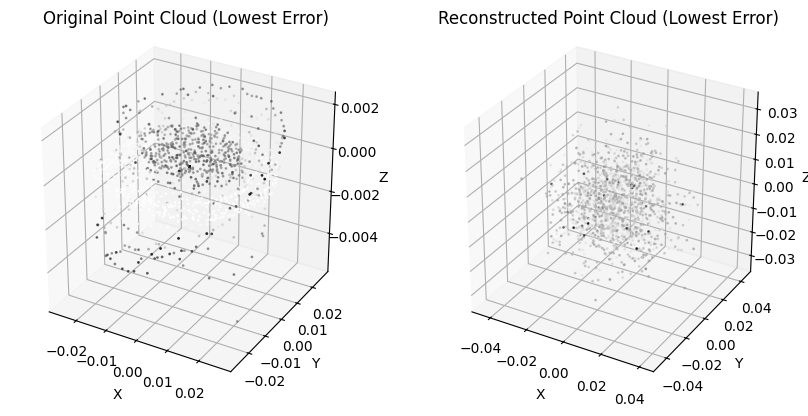

In [ ]:
def plot_point_cloud(points, colors, title, ax):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for all axes


model.to(device)

error, (points_np, colors_np), filename = pointcloud_info[-1]  # Extract points, colors, and filename
print(error)
# Convert points and colors to tensors and move them to the device
points = torch.tensor(points_np, dtype=torch.float32).to(device)
colors = torch.tensor(colors_np, dtype=torch.float32).to(device)

# Ensure the model is in evaluation mode
model.eval()
with torch.no_grad():
    combined_input = torch.cat((points, colors), dim=2)  # Combine points and colors
    reconstructed_points, reconstructed_colors, _ = model(combined_input)

# Convert the data back to NumPy for plotting
original_points_np = points.squeeze(0).cpu().numpy()
original_colors_np = colors.squeeze(0).cpu().numpy()
reconstructed_points_np = reconstructed_points.squeeze(0).cpu().numpy()
reconstructed_colors_np = reconstructed_colors.squeeze(0).cpu().numpy()

# Plot the original and reconstructed point clouds
fig = plt.figure(figsize=(10, 5))

# Original Point Cloud
ax1 = fig.add_subplot(121, projection='3d')
plot_point_cloud(original_points_np, original_colors_np, "Original Point Cloud (Lowest Error)", ax1)

# Reconstructed Point Cloud
ax2 = fig.add_subplot(122, projection='3d')
plot_point_cloud(reconstructed_points_np, reconstructed_colors_np, "Reconstructed Point Cloud (Lowest Error)", ax2)

plt.show()

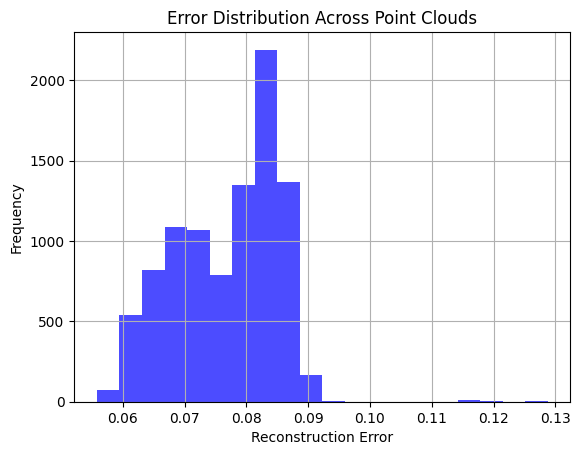

In [ ]:
def plot_error_distribution(errors_list):
    plt.hist(errors_list, bins=20, color='blue', alpha=0.7)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Error Distribution Across Point Clouds")
    plt.grid(True)
    plt.show()

errors = [info[0] for info in pointcloud_info]
plot_error_distribution(errors)

In [ ]:
low_threshold = 0
high_error_threshold = 2

high_error_pointclouds = [
    (error, pointcloud_data, filename)
    for error, pointcloud_data, filename in pointcloud_info
    if error < high_error_threshold and error >= low_threshold
]

print(f"Found {len(high_error_pointclouds)} point clouds")

Found 9467 point clouds


In [ ]:
for error, (points, colors), filename in high_error_pointclouds:
    # Prepend the error value to the filename
    points = np.asarray(points, dtype=np.float64).squeeze(0)
    colors = np.asarray(colors, dtype=np.float64).squeeze(0)
    save_point_cloud_as_ply(points, colors, f"{error:.4f}_{filename}.ply", "/content/t")

zip_folder("/content/t", "/content/t")

Saved point cloud to /content/t/1.0003_('2024-09-02_155419_243301-12_tray-b-4-f_L2_part_1_downsample_10_without_ears_seg_pipes_circle_125.ply',).ply
Saved point cloud to /content/t/0.9970_('2024-09-02_155419_243301-12_tray-b-4-f_L2_part_2_downsample_10_without_ears_seg_pipes_circle_103.ply',).ply
Saved point cloud to /content/t/0.9951_('tray-b-4-e_L2_part_4_downsample_10_without_ears_seg_pipes_circle_128.ply',).ply
Saved point cloud to /content/t/0.9871_('2024-09-02_161540_243301-13_tray-b-4-e_L2_part_4_downsample_10_without_ears_seg_pipes_circle_128.ply',).ply
Saved point cloud to /content/t/0.9847_('tray-b-4-a_L2_part_4_downsample_10_without_ears_seg_pipes_circle_128.ply',).ply
Saved point cloud to /content/t/0.9843_('tray-b-4-b_L2_part_4_downsample_10_without_ears_seg_pipes_circle_128.ply',).ply
Saved point cloud to /content/t/0.9830_('2024-09-02_161540_243301-13_tray-b-4-a_L2_part_2_downsample_10_without_ears_seg_pipes_circle_109.ply',).ply
Saved point cloud to /content/t/0.9822_('

In [ ]:
from sklearn.cluster import KMeans
all_points_flattened = []
error_replicated = []

for error, (pointcloud, _) , _ in high_error_pointclouds:
    points = np.asarray(pointcloud).reshape(-1, 3)
    all_points_flattened.append(points)
    error_replicated.extend([error] * points.shape[0])

all_points_flattened = np.vstack(all_points_flattened)
error_replicated = np.array(error_replicated)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(all_points_flattened)
labels = kmeans.labels_

In [ ]:
# Plot the clusters and color by error values
plt.scatter(all_points_flattened[:, 0], all_points_flattened[:, 1], c=error_replicated, cmap='viridis')
plt.colorbar(label='Error')
plt.title('KMeans Clustering of Point Clouds with Error')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

# Plot the clusters by KMeans labels
plt.scatter(all_points_flattened[:, 0], all_points_flattened[:, 1], c=labels, cmap='tab10')
plt.title('KMeans Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

KeyboardInterrupt: 

In [ ]:
import pandas as pd
mean_coords = []
std_coords = []
error_values = []

# Calculate the mean and standard deviation for each point cloud
for error, (pointcloud, _) , _ in high_error_pointclouds:
    points = np.asarray(pointcloud)
    mean_coords.append(np.mean(points, axis=0))  # Mean of the coordinates
    std_coords.append(np.std(points, axis=0))    # Standard deviation of the coordinates
    error_values.append(error)

# Convert to DataFrame for easy analysis
df = pd.DataFrame({
    'mean_x': [x[0] for x in mean_coords],
    'mean_y': [x[1] for x in mean_coords],
    'mean_z': [x[2] for x in mean_coords],
    'std_x': [x[0] for x in std_coords],
    'std_y': [x[1] for x in std_coords],
    'std_z': [x[2] for x in std_coords],
    'error': error_values
})

# Compute correlations
correlation_matrix = df.corr()

# Plot the correlation matrix
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Point Cloud Statistics and Error')
plt.show()

# You can also plot individual relationships
plt.scatter(df['mean_x'], df['error'])
plt.title('Mean X vs Error')
plt.xlabel('Mean X')
plt.ylabel('Error')
plt.show()

ValueError: setting an array element with a sequence.